In [2]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.tensorflow

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression

import joblib
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
# from sns.

mlflow.autolog()

2026/02/24 09:22:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2026/02/24 09:22:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2026/02/24 09:22:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


In [3]:
df = pd.read_csv("./Steel_industry_data.csv")
df.head()


,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


<Axes: xlabel='Day_of_week', ylabel='Count'>

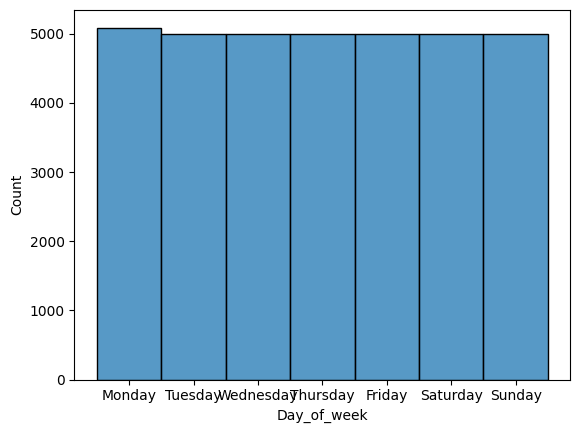

In [4]:


sns.histplot(
    df,
    x="Day_of_week"
 )


In [5]:
df.describe()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

In [7]:
df.nunique()

date                                    35040
Usage_kWh                                3343
Lagging_Current_Reactive.Power_kVarh     1954
Leading_Current_Reactive_Power_kVarh      768
CO2(tCO2)                                   8
Lagging_Current_Power_Factor             5079
Leading_Current_Power_Factor             3366
NSM                                        96
WeekStatus                                  2
Day_of_week                                 7
Load_Type                                   3
dtype: int64

In [8]:
X = df.drop(labels=["date", "Usage_kWh"], axis=1)
y = df.Usage_kWh

# y s'appel "cible" ou "target"
# x les données

In [9]:
# CREER LE PIPELINE

# Pipeline pour transformer les categories dans une seule colonne en boolean. "one hot encoding"
# Normalise les informations des datas mean et std (standard deviation-> écart type) à 0 et 1 
# StandardScaler sert à normaliser le mean à 0 et std à 1

scaler = StandardScaler() # Quand std à un on "détruit l'unité" => Les éléments sont comparables entre eux lorsque rammené à un
encoder = OneHotEncoder(sparse_output = False, drop = "first") # drop = "first" drop la catégorie sans informations (la premiére xD)
ordinal = OrdinalEncoder()

# faire 4 tableau, & pour les datas en Float, 1 tableau pour les One Hot Encoding (transformer les datas non numeriques utilisables en datas numeriques ), un 3e pour les Boolean (Weekstatus ne compte que deux uniques), et le 4e pour les entiers
data_float = [
    # "Lagging_Current_Reactive.Power_kVarh", # lorsque pas cités dans la list, transformer considére que ls colonnes n'éxiste pas (alternative à drop)
    # "Leading_Current_Reactive_Power_kVarh",
    # "CO2(tCO2)",
    "Lagging_Current_Power_Factor",
    "Leading_Current_Power_Factor"
    ]

data_int = ["NSM"]

data_ohe = [
    "Day_of_week",
    "Load_Type"
    ]

data_bool = ["WeekStatus"]

# Preprocessor, avant entrainement, définir ce qui arrive à chaque catégories,
preprocessor = ColumnTransformer(
    transformers=[
        ("num", scaler, data_float),
        ("cat", encoder, data_ohe),
        ("bool", ordinal , data_bool),
        ("int", "passthrough", data_int)
    ]
)

#  Définir le Pipeline qui lance le processeur, et le classifier de regression linéaire
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LinearRegression()),
    ]
)


In [10]:
# Séparer le X et y en données entrainement et données de tests
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# lance la pipeline avec les données d'entrainement
model = pipeline.fit(X_train, y_train)

2026/02/24 09:22:27 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/24 09:22:27 INFO mlflow.store.db.utils: Updating database tables
2026/02/24 09:22:29 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a00f66f02fe944279e4d2604be9c3de9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2026/02/24 09:22:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/anna/Documents/Alternance Février 2026/projet_acier/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample

In [11]:
score1 = model.score(X_test, y_test)
score1
# :) 

0.6174669243329236

In [12]:
score2 = model.score(X_train, y_train)
score2

0.6185586839702484

Le model 'et pas le plus efficace mais ne donne pas un résultat de 1 qui annoncerai que le model à juste appris par coeur les réponses (overfitting)

In [13]:
prediction = model.predict(X_test) # Doit donner y_test



2026/02/24 09:22:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/anna/Documents/Alternance Février 2026/projet_acier/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


In [14]:
mae = mean_absolute_error(prediction, y_test)
mse = mean_squared_error(prediction, y_test)
r2 = r2_score(prediction, y_test)

In [15]:
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"R2 : {r2}")

MAE : 15.261722607900635
MSE : 434.83389205858845
R2 : 0.37084202772924235


 ```bash 
 $ uv add mlflow
 $ mlflow ui
 ```

In [ ]:

mlflow.set_tracking_uri("http://127.0.0.1:5000")
with mlflow.start_run():
    model = pipeline.fit(X_train, y_train)
    predictions = model.predict(X_test)

    mlflow.log_param("model_type", "Linear Regression")
    # mlflow.log_metric("mse", mean_squared_error(y_test, predictions))
    # mlflow.log_metric("mae", mean_absolute_error(y_test, predictions)) # mlflow.autolog remplace automatiquement ces metriques + 1
    # mlflow.log_metric("r2", r2_score(y_test, predictions))

    mlflow.sklearn.log_model(model, "linear_regression_model")
    print(f"Model logged with MSE: {mean_squared_error(y_test, predictions)}")

2026/02/24 09:35:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/anna/Documents/Alternance Février 2026/projet_acier/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/02/24 09:35:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home

Model logged with MSE: 434.83389205858845
🏃 View run industrious-fawn-108 at: http://127.0.0.1:5000/#/experiments/0/runs/a819dbf2b1314fbe8780bc54edbd15a6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
